In [1]:
import numpy as np
import pandas as pd

from sklearn.datasets import load_iris

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

#分類問題
from sklearn.tree import DecisionTreeClassifier

from sklearn import metrics

from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
iris_dataset = load_iris()

X_columns = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
X = pd.DataFrame(iris_dataset.data, columns=X_columns)
y = pd.DataFrame(iris_dataset.target, columns=["Species"])
df = pd.concat([X, y], axis=1)

df = df.loc[:, ["petal_length", "petal_width", "Species"]]
df.head()

,petal_length,petal_width,Species
0,1.4,0.2,0
1,1.4,0.2,0
2,1.3,0.2,0
3,1.5,0.2,0
4,1.4,0.2,0


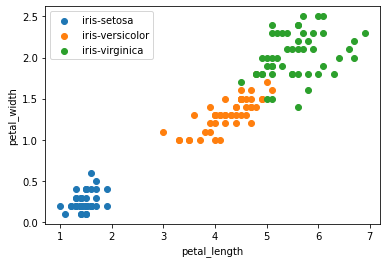

In [3]:
plt.scatter(df[(df['Species'] == 0).values]['petal_length'],
            df[(df['Species'] == 0).values]['petal_width'],
            label = 'iris-setosa',
            cmap = 'viridis')

plt.scatter(df[(df['Species'] == 1).values]['petal_length'],
            df[(df['Species'] == 1).values]['petal_width'],
            label = 'iris-versicolor',
            cmap = 'viridis')

plt.scatter(df[(df['Species'] == 2).values]['petal_length'],
            df[(df['Species'] == 2).values]['petal_width'],
            label = 'iris-virginica',
            cmap = 'viridis')

plt.xlabel('petal_length')
plt.ylabel('petal_width')
plt.legend()
plt.show()

In [4]:
class DecisionTreeNode(object):
    """
    決定木分類器のノードクラス

    Parameters
    ----------
    max_depth : int
      決定木の深さ
    X : 次の形のndarray, shape (n_samples, n_features)
        各ノードの特徴量
    y : 次の形のndarray, shape (n_samples, )
        各ノードの正解値
    """
    def __init__(self, X, y, max_depth):
        # ハイパーパラメータを属性として記録
        self.left_class = None
        self.right_class = None
        self.max_depth = max_depth
        self.depth = None
        self.X = X
        self.y = y
        self.best_threshold = None
        self.best_feature = None
        self.gini_impurity_min = None
        self.label = np.argmax(np.bincount(y)) #各ノードに含まれるサンプルのうち、最も多いクラスラベル                
        self.classes = np.unique(y) # 各ノード所在のクラス値
        self.n_features_ = X.shape[1] # 各ノード所在の列数
        self.total_sample = len(y) # 各ノード所在のサンプルの総数
        
    def __compute_gini_impurity__(self, X, y, feature_index, threshold):
        """
        ジニ不純度を計算する関数
        __search_best_split__より呼ばれる
        """
        gini_impurity = 0

        # search_best_splitより渡されたvalueをthresholdに見立て、
        # 該当の特徴量に対応するy変数を閾値以上の列と閾値未満の列に分割
        divide_y = [y[X[:, feature_index] >= threshold], y[X[:, feature_index] < threshold]]

        # ジニ不純度の計算
        for array_group in divide_y:
            sum_square_sample_rate = 0
            for class_ in self.classes:
                p = np.sum(array_group == class_)/len(array_group)
                sum_square_sample_rate += np.square(p)
            gini_impurity += (1 - sum_square_sample_rate) * (len(array_group) / self.total_sample)

        return gini_impurity
        
    def __search_best_split__(self, X, y):
        """
        最良の閾値でサンプルを分割する関数
        特徴量別行別にジニ不純度を計算し、
        ジニ不純度が最小の値が最良の閾値を構成
        """
        best_threshold = None
        best_feature = None
        gini_impurity = None
        gini_impurity_min = 1 #初期に最大値1を設定

        for feature_index in range(self.n_features_):
            values = X[:, feature_index]
            for value in values:
                gini_impurity = self.__compute_gini_impurity__(X, y, feature_index, value)
                if gini_impurity_min > gini_impurity:
                    gini_impurity_min = gini_impurity
                    best_threshold = value
                    best_feature = feature_index
                    
        return gini_impurity_min, best_threshold, best_feature 
    
    def __split__(self, depth):        
        self.depth = depth # 現在の深さ
        self.gini_impurity_min, self.best_threshold, self.best_feature = self.__search_best_split__(self.X, self.y)
        print('Depth: {}, Sep at Feature: {},Threshold: {}, Label: {}'
              .format(self.depth, self.best_feature, self.best_threshold, self.label))

        # 木の深さがmax_depthに達したとき、又は、ジニ不純度が0になったときは処理を終了
        if self.depth == self.max_depth or self.gini_impurity_min == 0:
            return
        
        #  最良の閾値以上の左列と最良の閾値未満の右列に分割(True, False)
        index_left = self.X[:, self.best_feature] >= self.best_threshold
        index_right = self.X[:, self.best_feature] < self.best_threshold
        
        # 左側・右側の子ノードのインスタンスを生成
        self.left_class = DecisionTreeNode(self.X[index_left],  self.y[index_left], self.max_depth)
        self.right_class = DecisionTreeNode(self.X[index_right], self.y[index_right], self.max_depth)
        
        # 深さをプラス1した上で、生成した左側・右側の子ノードのインスタンスよりsplit関数を再帰的に処理
        self.left_class.__split__(self.depth + 1)
        self.right_class.__split__(self.depth + 1)
        
    def __predict__(self, X_features):
        # 木の深さがmax_depthに達したとき、又は、ジニ不純度が0になったときは処理を終了
        # 各ノードに含まれているサンプルのうち最も多いクラスをリターン
        if self.gini_impurity_min == 0.0 or self.depth == self.max_depth:
            return self.label
        else:
            # 行毎に渡された特徴量Xに対して、最良の特徴量が最良の閾値以上のときは左側の子ノード
            if X_features[self.best_feature] >= self.best_threshold:
                return self.left_class.__predict__(X_features)
            else:
                return self.right_class.__predict__(X_features)    
    
class ScratchDesicionTreeClassifier(object):
    """
    決定木分類器のスクラッチ実装

    Parameters
    ----------
    max_depth : int
      決定木の深さ
    """
    def __init__(self, max_depth):
        self.max_depth = max_depth
        self.tree = None
   
    def fit(self, X, y):
        """
        決定木分類器を学習する
        DecisionTreeNodeの子オブジェクトを再帰的に生成
        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            訓練データの特徴量
        y : 次の形のndarray, shape (n_samples, )
            訓練データの正解値
        """ 
        initial_depth = 0
        self.tree = DecisionTreeNode(X, y, self.max_depth)
        self.tree.__split__(initial_depth)
   
    def predict(self, X):
        """
        決定木分類器を使いラベルを推定する
        """
        y_pred = []
        for X_features in X:
            y_pred.append(self.tree.__predict__(X_features))

        return np.array(y_pred)

In [5]:
X = df.iloc[:, [0, 1]].values
y = df.iloc[:, 2].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=3) 

In [6]:
def evaluate(y, y_pred):
    """
    2値分類の評価指標を計算・描画する。
    """
    acc = metrics.accuracy_score(y, y_pred)
    precision = metrics.precision_score(y, y_pred, average='micro')
    recall = metrics.recall_score(y, y_pred, average='micro')
    f1 = metrics.f1_score(y, y_pred, average='micro')
    
    plt.figure(figsize=(1.6, 1.2))
    cm_def = metrics.confusion_matrix(y, y_pred)
    sns.heatmap(cm_def, annot=True, cmap='Blues')
    plt.title('Confusion Matrix')
    plt.show()
    return acc, precision, recall, f1

__scratch 決定木__

In [7]:
model = ScratchDesicionTreeClassifier(max_depth=1)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_pred

Depth: 0, Sep at Feature: 0,Threshold: 3.0, Label: 1
Depth: 1, Sep at Feature: 0,Threshold: 4.8, Label: 1
Depth: 1, Sep at Feature: 0,Threshold: 1.7, Label: 0


/Users/takahiromotoki/.pyenv/versions/anaconda3-2019.10/lib/python3.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in long_scalars


array([0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0,
       1])

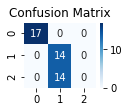

Accuracy : 0.69
Precision : 0.69
Recall : 0.69
F1 : 0.69



In [8]:
print('Accuracy : {:.2f}\n'
      'Precision : {:.2f}\n'
      'Recall : {:.2f}\n'
      'F1 : {:.2f}\n'
      .format(*evaluate(y_test, y_pred)))

__scikit-learn 決定木__

In [9]:
dt_model = DecisionTreeClassifier(max_depth=1)
dt_model.fit(X_train, y_train.ravel())
dt_pred = dt_model.predict(X_test)
dt_pred

array([0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0,
       1])

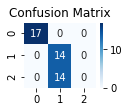

Accuracy : 0.69
Precision : 0.69
Recall : 0.69
F1 : 0.69



In [10]:
print('Accuracy : {:.2f}\n'
      'Precision : {:.2f}\n'
      'Recall : {:.2f}\n'
      'F1 : {:.2f}\n'
      .format(*evaluate(y_test, dt_pred)))

### 【問題1】不純度を求める関数
ノード の ジニ不純度 を計算する関数を作成してください。ノード $t$ に対するジニ不純度 $I(t)$ は以下の数式で求まります。クラスが混じり合っているほどジニ不純度は高くなります。

$$
I(t)=1-\displaystyle \sum_{i=1}^K P^2(C_{i}|t)
= 1-\displaystyle \sum_{i=1}^K (\frac{N_{t,i}}{N_{t,all}})^2
$$


$t$ : ノードのインデックス


$i$ : クラスのインデックス


$K$ : クラスの数


$C_i$ : i番目のクラス


$P(C_i|t)$ :　t番目のノードにおける$C_i$の割合


$N_{t,i}$ : t番目のノードのi番目のクラスに属するサンプル数


$N_{t,all}$ : t番目のノードのサンプルの総数


まずは簡単な例を作り、手計算と関数の結果を比較してください。


《例》


- クラス1:サンプル数15, クラス2:サンプル数15 → ジニ不純度0.500
- クラス1:サンプル数15, クラス2:サンプル数15, クラス3:サンプル数15 → ジニ不純度0.667
- クラス1:サンプル数18, クラス2:サンプル数12 → ジニ不純度0.480
- クラス1:サンプル数30, クラス2:サンプル数0 → ジニ不純度0.000

### 【問題2】情報利得を求める関数
次に、ノード間の 情報利得 を計算する関数を作成してください。問題1で作成したジニ不純度 $I(t)$ を計算する関数を呼び出して使います。情報利得$IG$は以下の数式で求まります。うまく分けられている時ほど情報利得は大きくなります。


ここで分岐は2つのみであるため、分岐先を「左側のノード・右側のノード」と呼びます。

$$
IG(p) = I(p) - \frac{N_{left,all}}{N_{p,all}}I(left) - \frac{N_{right,all}}{N_{p,all}}I(right)
$$


$p$ : 親ノードを示すインデックス


$left$ : 左側のノードを示すインデックス


$right$ : 右側のノードを示すインデックス


まずは簡単な例を作り、手計算と関数の結果を比較してください。


《例》


左ノードクラス1:サンプル数10, 左ノードクラス2:サンプル数30, 右ノードクラス1:サンプル数20, 右ノードクラス2:サンプル数5 → 情報利得0.143

### 【問題3】学習
空間の分割を行い、決定木のグラフを生成するコードを作成してください。今は深さ1の決定木なので、分割を1回だけ行います。ここでグラフを生成するとは、1回の分割の際の条件としてどの特徴量がいくつ以上の時とするかを求めるということです。


訓練データに対して全ての組み合わせの分割を行い、その中でノード間の情報利得が最大となる分割をそのノードの分割基準として記録します。


クラスが混ざらない不純度が0のノード、または指定された深さのノードが __葉ノード__ となります。葉ノードにはクラスを記録しておき、これを推定時に分類するクラスとします。クラスが混ざらない場合はそのままのクラスを記録し、混ざっている場合は多数決により決めます。


《組み合わせの取り方》


全ての組み合わせの取り方は、最も単純には各特徴量の値自体をしきい値にして分割を行う方法があります。片側の端は今回のスクラッチはこの方法で行なってください。


他には中間の値をしきい値にする方法もあり、scikit-learnではこの方法が用いられています。


《補足》


問題2の情報利得を計算する関数はこの問題3で利用する上では、親ノードの不純度 $I(p)$ は固定されるため、左右のノードの不純度の合計を計算するだけでも同じ結果が得られることになります。しかし、ここでは親ノードを考慮した情報利得を計算する実装を行なってください。

### 【問題4】推定
推定する仕組みを実装してください。ScratchDecesionTreeClassifierDepth1クラスの雛形に含まれるpredictメソッドに書き加えてください。


入力されたデータの値を学習した条件で判定していき、どの葉ノードに到達するかを見ます。葉ノードにはクラスが記録されているので、これが推定値となります。

### 【問題5】学習と推定
機械学習スクラッチ入門のSprintで用意したシンプルデータセット2の2値分類に対してスクラッチ実装の学習と推定を行なってください。


scikit-learnによる実装と比べ、正しく動いているかを確認してください。


AccuracyやPrecision、Recallなどの指標値はscikit-learnを使用してください。

#### 3. シンプルデータセット2

In [11]:
X = np.array([[-0.44699 , -2.8073  ],[-1.4621  , -2.4586  ],
       [ 0.10645 ,  1.9242  ],[-3.5944  , -4.0112  ],
       [-0.9888  ,  4.5718  ],[-3.1625  , -3.9606  ],
       [ 0.56421 ,  0.72888 ],[-0.60216 ,  8.4636  ],
       [-0.61251 , -0.75345 ],[-0.73535 , -2.2718  ],
       [-0.80647 , -2.2135  ],[ 0.86291 ,  2.3946  ],
       [-3.1108  ,  0.15394 ],[-2.9362  ,  2.5462  ],
       [-0.57242 , -2.9915  ],[ 1.4771  ,  3.4896  ],
       [ 0.58619 ,  0.37158 ],[ 0.6017  ,  4.3439  ],
       [-2.1086  ,  8.3428  ],[-4.1013  , -4.353   ],
       [-1.9948  , -1.3927  ],[ 0.35084 , -0.031994],
       [ 0.96765 ,  7.8929  ],[-1.281   , 15.6824  ],
       [ 0.96765 , 10.083   ],[ 1.3763  ,  1.3347  ],
       [-2.234   , -2.5323  ],[-2.9452  , -1.8219  ],
       [ 0.14654 , -0.28733 ],[ 0.5461  ,  5.8245  ],
       [-0.65259 ,  9.3444  ],[ 0.59912 ,  5.3524  ],
       [ 0.50214 , -0.31818 ],[-3.0603  , -3.6461  ],
       [-6.6797  ,  0.67661 ],[-2.353   , -0.72261 ],
       [ 1.1319  ,  2.4023  ],[-0.12243 ,  9.0162  ],
       [-2.5677  , 13.1779  ],[ 0.057313,  5.4681  ]])
y = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

__scratch 決定木__

In [12]:
model = ScratchDesicionTreeClassifier(max_depth=1)
model.fit(X, y.ravel())
y_pred = model.predict(X)
y_pred

Depth: 0, Sep at Feature: 1,Threshold: 5.3524, Label: 0
Depth: 1, Sep at Feature: 0,Threshold: -0.12243, Label: 1
Depth: 1, Sep at Feature: 1,Threshold: 2.5462, Label: 0


/Users/takahiromotoki/.pyenv/versions/anaconda3-2019.10/lib/python3.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in long_scalars


array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1])

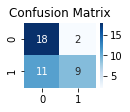

Accuracy : 0.68
Precision : 0.68
Recall : 0.68
F1 : 0.68



In [13]:
print('Accuracy : {:.2f}\n'
      'Precision : {:.2f}\n'
      'Recall : {:.2f}\n'
      'F1 : {:.2f}\n'
      .format(*evaluate(y, y_pred)))

__scikit-learn 決定木__

In [14]:
dt_model = DecisionTreeClassifier(max_depth=1)
dt_model.fit(X, y.ravel())
dt_pred = dt_model.predict(X)
dt_pred

array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1])

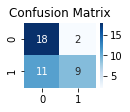

Accuracy : 0.68
Precision : 0.68
Recall : 0.68
F1 : 0.68



In [15]:
print('Accuracy : {:.2f}\n'
      'Precision : {:.2f}\n'
      'Recall : {:.2f}\n'
      'F1 : {:.2f}\n'
      .format(*evaluate(y, dt_pred)))

### 【問題6】決定領域の可視化
決定領域を可視化してください。

In [16]:
def decision_region(X, y, model, step=0.01, title='decision region',
                    xlabel='f0', ylabel='f1', target_names=['0', '1']):
    """
    2値分類を2次元の特徴量で学習したモデルの決定領域を描く。
    背景の色が学習したモデルによる推定値から描画される。
    散布図の点は訓練データまたは検証データである。

    Parameters
    ----------------
    X : ndarray, shape(n_samples, 2)
        特徴量
    y : ndarray, shape(n_samples,)
        ラベル
    model : object
        学習したモデルのインスンタスを入れる
    step : float, (default : 0.1)
        推定値を計算する間隔を設定する
    title : str
        グラフのタイトルの文章を与える
    xlabel, ylabel : str
        軸ラベルの文章を与える
    target_names= : list of str
        凡例の一覧を与える
    """
    # setting
    scatter_color = ['red', 'blue']
    contourf_color = ['pink', 'skyblue']
    n_class = 2
    # pred
    mesh_f0, mesh_f1  = np.meshgrid(np.arange(np.min(X[:,0])-0.5,
                                              np.max(X[:,0])+0.5, step),
                                    np.arange(np.min(X[:,1])-0.5,
                                              np.max(X[:,1])+0.5, step))

    mesh = np.c_[np.ravel(mesh_f0),np.ravel(mesh_f1)]
    y_pred = model.predict(mesh).reshape(mesh_f0.shape)
    # plot
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.contourf(mesh_f0, mesh_f1, y_pred, n_class-1, cmap=ListedColormap(contourf_color))
    plt.contour(mesh_f0, mesh_f1, y_pred, n_class-1, colors='y', linewidths=3, alpha=0.5)
    for i, target in enumerate(set(y)):
        plt.scatter(X[y==target][:, 0], X[y==target][:, 1], s=80,
                    color=scatter_color[i], label=target_names[i], marker='o')
    patches = [mpatches.Patch(color=scatter_color[i], label=target_names[i]) for i in range(n_class)]
    plt.legend(handles=patches)
    plt.legend()
    plt.show()

__scratch 決定木__

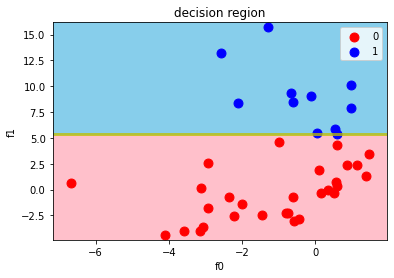

In [17]:
decision_region(X, y_pred, model)

__scikit-learn 決定木__

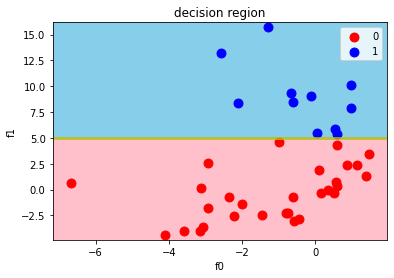

In [18]:
decision_region(X, dt_pred, dt_model)

### 【問題7】（アドバンス課題）深さ2の決定木分類器クラスの作成
深さが2の決定木分類器のクラスScratchDecesionTreeClassifierDepth2を作成してください。


深さ2とは空間の分割を2回行うことを指します。


《ヒント》


各ノードをインスタンスとして扱うと、任意の深さへの拡張が行いやすくなります。

### 【問題8】（アドバンス課題）深さに制限のない決定木分類器クラスの作成
深さに制限のない決定木分類器のクラスScratchDecesionTreeClassifierDepthInfを作成してください。


任意の深さを指定できるようにするとともに、指定しない場合は全ての葉ノードがジニ不純度0となるまで続けられるようにもしてください。

In [19]:
iris_dataset = load_iris()

X_columns = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
X = pd.DataFrame(iris_dataset.data, columns=X_columns)

y = pd.DataFrame(iris_dataset.target, columns=["Species"])

df = pd.concat([X, y], axis=1)

X = df.iloc[:, :4].values
y = df.iloc[:, 4].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=3) 

__scratch 決定木__

In [20]:
model = ScratchDesicionTreeClassifier(max_depth=3)
model.fit(X, y.ravel())
y_pred = model.predict(X)
y_pred

Depth: 0, Sep at Feature: 2,Threshold: 3.0, Label: 0
Depth: 1, Sep at Feature: 3,Threshold: 1.8, Label: 1
Depth: 2, Sep at Feature: 2,Threshold: 4.9, Label: 2
Depth: 3, Sep at Feature: 0,Threshold: 6.3, Label: 2
Depth: 3, Sep at Feature: 0,Threshold: 6.0, Label: 2
Depth: 2, Sep at Feature: 2,Threshold: 5.0, Label: 1
Depth: 3, Sep at Feature: 3,Threshold: 1.6, Label: 2
Depth: 3, Sep at Feature: 3,Threshold: 1.7, Label: 1
Depth: 1, Sep at Feature: 0,Threshold: 5.1, Label: 0


/Users/takahiromotoki/.pyenv/versions/anaconda3-2019.10/lib/python3.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in long_scalars


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

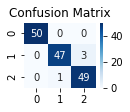

Accuracy : 0.97
Precision : 0.97
Recall : 0.97
F1 : 0.97



In [21]:
print('Accuracy : {:.2f}\n'
      'Precision : {:.2f}\n'
      'Recall : {:.2f}\n'
      'F1 : {:.2f}\n'
      .format(*evaluate(y, y_pred)))

__scikit-learn 決定木__

In [22]:
dt_model = DecisionTreeClassifier(max_depth=3)
dt_model.fit(X, y.ravel())
dt_pred = dt_model.predict(X)
dt_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

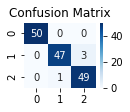

Accuracy : 0.97
Precision : 0.97
Recall : 0.97
F1 : 0.97



In [23]:
print('Accuracy : {:.2f}\n'
      'Precision : {:.2f}\n'
      'Recall : {:.2f}\n'
      'F1 : {:.2f}\n'
      .format(*evaluate(y, dt_pred)))

[参考にしたサイト](https://hktech.hatenablog.com/entry/2018/10/05/004235)\
SVMより理論は理解し易いものであったが、\
任意の特徴量を閾値としてサンプルを分割した上で決定木の理論を組み込む過程が難解であったため、\
上記サイトを全て理解して若干修正を加えた。